In [2]:
import numpy as np
import torch
from pathlib import Path
from transformers import AutoTokenizer

In [3]:
a_log_dir = Path("~/tmp/F/").expanduser().resolve()
b_log_dir = Path("koi/F/").expanduser().resolve()
#log_dir = Path(".").expanduser().resolve()
#log_dir = Path("~/tmp/AC/").expanduser().resolve()
a_logits_mnal = a_log_dir / "logits.mnal"
a_idx_mnal = a_log_dir / "idx.mnal"

In [5]:
class RunLog:
    def __init__(self, log_dir, logits_width=50304):
        self.log_dir = log_dir
        self.logits_width = logits_width
        self.logits_mnal = log_dir / "logits.mnal"
        self.idx_mnal = log_dir / "idx.mnal"
        self.idx_dtype = np.dtype('int64')
        self.length, rem = divmod(self.idx_mnal.stat().st_size, self.idx_dtype.itemsize)
        assert rem==0, "Weird length idx"
        self.logits_bytes_size, rem = divmod(self.logits_mnal.stat().st_size, self.length)
        assert rem==0, "Weird length logits"
        self.logits_itemsize, rem = divmod(self.logits_bytes_size, self.logits_width)
        assert rem==0, "Weird logits_bytes_size"
        self.logits_dtype = np.dtype(('float0', 
                                      'float8',
                                      'float16',
                                      'float24',
                                      'float32')[self.logits_itemsize])
        self.logits_stack = np.memmap(self.logits_mnal,
                                      self.logits_dtype,
                                      'r',
                                      shape=(self.length, self.logits_width)).squeeze()
        self.idx_stack = np.memmap(self.idx_mnal,
                                   self.idx_dtype,
                                   'r',
                                    shape=(self.length,)).squeeze()


In [6]:
srl = RunLog(Path("~/tmp/F/").expanduser().resolve())
srl.length, srl.logits_width, srl.logits_itemsize, srl.logits_dtype, srl.logits_stack.shape, srl.idx_stack.shape

(131072, 50304, 2, dtype('float16'), (131072, 50304), (131072,))

In [7]:
krl = RunLog(Path("koi/F/").expanduser().resolve())
krl.length, krl.logits_width, krl.logits_itemsize, krl.logits_dtype, krl.logits_stack.shape, krl.idx_stack.shape

(131072, 50304, 2, dtype('float16'), (131072, 50304), (131072,))

In [8]:
a = srl.logits_stack
a.shape

(131072, 50304)

In [16]:
# Iterate through each column and check if all elements are zero
for i in range(a.shape[0]):
    if np.all(a[i] == 0.0):
        first_all_zero_row = i
        break
else:
    # This block executes if no column with all zeros is found
    first_all_zero_row = None

if first_all_zero_row is not None:
    print("First row where all elements are zero:", first_all_zero_row)
else:
    print("No row with all elements zero found")

First row where all elements are zero: 114255


In [14]:
np.all(a[-1] == 0.0)

True

In [33]:
np.all(srl.idx_stack == krl.idx_stack), np.allclose(srl.logits_stack[:10], krl.logits_stack[:10])

(True, False)

In [105]:
srl.logits_stack.shape, srl.logits_stack

((131072, 50304),
 memmap([[ 6.848 , 12.81  ,  8.74  , ..., -6.777 , -6.777 , -6.777 ],
         [ 1.686 ,  0.89  ,  4.3   , ..., -3.508 , -3.508 , -3.506 ],
         [-0.8223, -0.3289,  0.9033, ..., -2.62  , -2.62  , -2.617 ],
         ...,
         [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
         [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
         [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]],
        dtype=float16))

In [217]:
def quantize(v,q=qw):
    vmax = np.max(v)
    norm = np.log(np.sum(np.exp(v-vmax))) + vmax
    v = v - norm + clip_logits
    v = v*(v>0)
    #v = np.log1p(v)
    return np.round(v/q)

In [234]:
def relate(a, b):
    return (np.max(a), np.max(b)), (np.max(a-b), np.min(a-b)) #), (np.max(a/b), np.min(a/b)), np.max(np.abs((a-b) / (np.abs(a) + np.abs(b))))

In [235]:
relate(srl.logits_stack[0], krl.logits_stack[0])

((16.3, 16.28), (0.01563, -0.03516))

In [239]:
relate(quantize(srl.logits_stack[0], 1.0), quantize(krl.logits_stack[0], 1.0))

((15.0, 15.0), (0.0, -1.0))

In [220]:
#Chat4:
def quantize_array(arr, quantization_width):
    """
    Quantize a numpy array by a specified quantization width.

    Parameters:
    arr (numpy.ndarray): The array to quantize.
    quantization_width (float): The width of each quantization level.

    Returns:
    numpy.ndarray: The quantized array.
    """
    quantized = np.round(arr / quantization_width) * quantization_width
    return quantized.astype(np.float16)

# Example usage
array = np.array([1.25, 2.35, 3.45], dtype=np.float16)
quantization_width = 0.1

quantized_array = quantize_array(array, quantization_width)
print(quantized_array)

[1.199 2.398 3.398]


In [221]:
qw = 0.03
sq, kq = quantize_array(srl.logits_stack[0], qw), quantize_array(krl.logits_stack[0], qw)
np.max(sq-kq), np.min(sq-kq)

(0.04688, -0.0625)

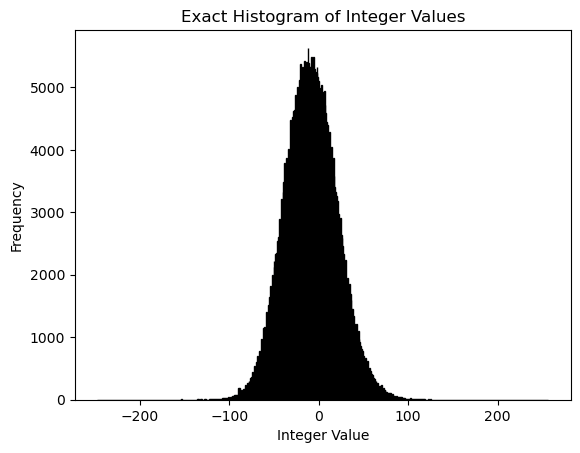

0.9925072227523325


In [222]:
qw = 0.1
sample_span = list(range(1024,1032))
ssamp, ksamp = srl.logits_stack[sample_span].flatten(), krl.logits_stack[sample_span].flatten()
sq, kq = np.round(ssamp / qw), np.round(ksamp / qw)
np.max(sq-kq), np.min(sq-kq), np.min(np.abs(ssamp/qw - sq))

import numpy as np
import matplotlib.pyplot as plt

def hist_plt(data, notch=None):
    # Determine the range of your data
    min_val = data.min()
    max_val = data.max()
    if notch is not None:
        data = data[data!=notch]
        
    # Create bins for each integer value
    # We add 1 to max_val to ensure the last bin is included
    bins = np.arange(min_val, max_val + 2) - 0.5
    
    # Plotting the histogram
    #plt.hist(data[data!=0], bins=bins, edgecolor='black')
    plt.hist(data, bins=bins, edgecolor='black')
    
    # Setting the labels and title
    plt.xlabel('Integer Value')
    plt.ylabel('Frequency')
    plt.title('Exact Histogram of Integer Values')
    
    # Show the plot
    plt.show()

hist_plt(sq)
print((np.sum((data==0)*1.0)/len(data)))

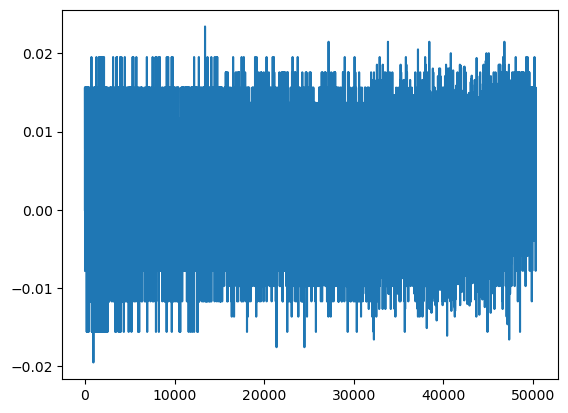

0.0


In [223]:
qw = 0.1
sample_span = [12345]
ssamp, ksamp = srl.logits_stack[sample_span].flatten(), krl.logits_stack[sample_span].flatten()
sq, kq = np.round(ssamp / qw), np.round(ksamp / qw)
np.max(sq-kq), np.min(sq-kq), np.min(np.abs(ssamp/qw - sq))

import numpy as np
import matplotlib.pyplot as plt

data = ssamp

# Determine the range of your data
min_val = data.min()
max_val = data.max()

# Create bins for each integer value
# We add 1 to max_val to ensure the last bin is included
bins = np.arange(min_val, max_val + 2) - 0.5

# Plotting the histogram
#plt.hist(data[data!=0], bins=bins, edgecolor='black')
#plt.plot(np.sort(data))
plt.plot((ssamp-ksamp)[np.argsort(ssamp)])

# Setting the labels and title
#plt.xlabel('Integer Value')
#plt.ylabel('Frequency')
#plt.title('Exact Histogram of Integer Values')

# Show the plot
plt.show()

print((np.sum((data==0)*1.0)/len(data)))

In [224]:
eot_ix = np.argmax(srl.idx_stack)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tok2str = lambda x: tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(x))
s = tok2str(srl.idx_stack[0:eot_ix])
print(s[2000:000])

In [225]:
np.argmax(logits_stack[0:eot_ix+3], axis=1)

NameError: name 'logits_stack' is not defined

In [226]:
print(tok2str(np.argmax(logits_stack[0:eot_ix], axis=1)))

NameError: name 'logits_stack' is not defined

In [ ]:
np.max(logits_stack[0:eot_ix], axis=1)

In [ ]:
np.mean(logits_stack[0:eot_ix], axis=1)

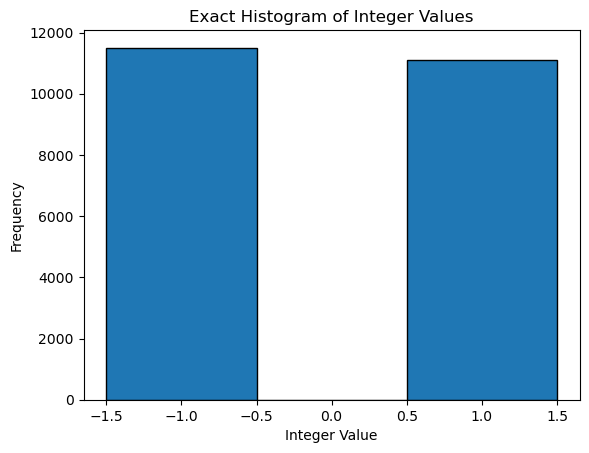

0.0
left: 0.4506232108778626
left prob: 0.9991753994538007
bits penalty: 0.019034353899456076


In [227]:
qw = 0.3
clip_logits = 16

sample_span = list(range(1000,1060))
ssamp, ksamp = np.array(srl.logits_stack[sample_span],dtype=np.float64), np.array(krl.logits_stack[sample_span],np.float64)
#ssamp = np.log(np.exp(ssamp)/np.sum(np.exp(ssamp)))
#ksamp = np.log(np.exp(ksamp)/np.sum(np.exp(ksamp)))
nsamp = np.array([v-np.log(np.sum(np.exp(v))) for v in ssamp])

sq, kq = tuple(np.array([quantize(v) for v in d]).flatten() for d in (ssamp,ksamp))
#np.max(sq-kq), np.min(sq-kq), np.min(np.abs(ssamp/qw - sq))

hist_plt(sq - kq, notch=0)

print((np.sum((data==0)*1.0)/len(data)))
print("left:",np.sum((sq>0)*1)/len(sq))
print("left prob:",np.sum(np.exp(nsamp.flatten()[sq>0]))/len(nsamp))
print("bits penalty:",(1-np.sum(np.exp(nsamp.flatten()[sq>0]))/len(nsamp)) * clip_logits/np.log(2))


In [242]:
torch.tensor(range(3))

tensor([0, 1, 2])

In [ ]:
torch.from_numpy

In [ ]:
torch.ones_like